In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
!unzip '/content/drive/MyDrive/Multi class Brain tumor Clssification/Dataset/Augmented + Split.zip'

unzip:  cannot find or open /content/drive/MyDrive/Multi class Brain tumor Clssification/Dataset/Augmented + Split.zip, /content/drive/MyDrive/Multi class Brain tumor Clssification/Dataset/Augmented + Split.zip.zip or /content/drive/MyDrive/Multi class Brain tumor Clssification/Dataset/Augmented + Split.zip.ZIP.


# Import Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras import layers
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1,EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

import os

2023-07-05 14:45:06.230213: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **Data Preperation**

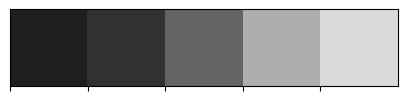

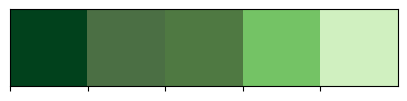

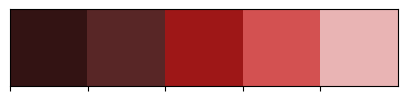

In [12]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [5]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [6]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image


# **Experiments on CE-MRI Figshare Brain Tumor Dataset**



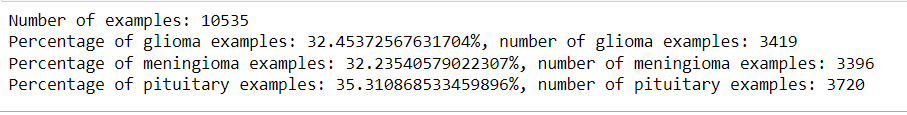

## **Steps**
1. Crop brain contunour
2. Split the dataset into train and test folder in 80:20 ratio
3. Generate augmented images for each class in train folder only
4. class folder name in both folder i.e. train and test should be glioma, meningioma, pituitary tumor


In [7]:
labels = ['glioma','meningioma','pituitary tumor']

In [8]:
X_train = []
y_train = []
X_test = []
y_test = []

print("Train Set")
print("===========")
image_size = 240
for i in labels:
  # path to the train folder
    folderPath = os.path.join('/content/Augmented + Split','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
                
X_train = np.array(X_train)
y_train = np.array(y_train)

print("Test Set")
print("=========")
for i in labels:
  # path to the test folder
    folderPath = os.path.join('/content/Augmented + Split','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_test.append(img)
        y_test.append(i)
                
X_test = np.array(X_test)
y_test = np.array(y_test)

Train Set


FileNotFoundError: [Errno 2] No such file or directory: '/content/Augmented + Split/train/glioma'

In [ ]:
# plot samples
k=0
fig, ax = plt.subplots(1,3,figsize=(20,20))

for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
# dataset shuffling
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_test, y_test = shuffle(X_test,y_test, random_state=101)

In [ ]:
X_train.shape

In [ ]:
print("x train=",X_train.shape)
print("y train=",y_train.shape)

print("x test=",X_test.shape)
print("y test=",y_test.shape)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
sns.countplot(y_train)

In [ ]:
sns.countplot(y_test)

In [ ]:
# label encoding

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

## **EfficientNet B1**

### **Load Weights**

In [9]:
effnet = EfficientNetB1(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

27018416/27018416 [==============================] - 5s 0us/step


In [10]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(3,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 240, 240, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 240, 240, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 240, 240, 3)  0           ['normalization[0][0]']      

 block2a_expand_conv (Conv2D)   (None, 120, 120, 96  1536        ['block1b_add[0][0]']            
                                )                                                                 
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 120, 120, 96  384        ['block2a_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block2a_expand_activation (Act  (None, 120, 120, 96  0          ['block2a_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 121, 121, 96  0          ['block2a_expand_activation[0][0]
 g2D)     

 ivation)                                                                                         
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 60, 60, 144)  1296       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 60, 60, 144)  576        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 60, 60, 144)  0          ['block2c_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block3b_activation (Activation  (None, 30, 30, 240)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block3b_se_reshape[0][0]']     
          

 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 240)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block4a_se_reduce[0][0]']      
          

                                                                                                  
 block4c_se_excite (Multiply)   (None, 15, 15, 480)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 15, 15, 80)   38400       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 15, 15, 80)  320         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 15, 15, 80)   0           ['block4c_project_bn[0][0]']     
          

                                                                                                  
 block5a_project_bn (BatchNorma  (None, 15, 15, 112)  448        ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 15, 15, 672)  75264       ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 15, 15, 672)  2688       ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5b_expand_activation (Act  (None, 15, 15, 672)  0          ['block5b_expand_bn[0][0]']      
 ivation) 

                                                                                                  
 block5d_expand_bn (BatchNormal  (None, 15, 15, 672)  2688       ['block5d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5d_expand_activation (Act  (None, 15, 15, 672)  0          ['block5d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5d_dwconv (DepthwiseConv2  (None, 15, 15, 672)  16800      ['block5d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5d_b

 block6b_dwconv (DepthwiseConv2  (None, 8, 8, 1152)  28800       ['block6b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6b_bn (BatchNormalization  (None, 8, 8, 1152)  4608        ['block6b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6b_activation (Activation  (None, 8, 8, 1152)  0           ['block6b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 1152)        0           ['block6b_activation[0][0]']     
 agePoolin

                                                                                                  
 block6d_activation (Activation  (None, 8, 8, 1152)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1152)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6d_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_se_excite (Multiply)   (None, 8, 8, 1152)   0           ['block7a_activation[0][0]',     
                                                                  'block7a_se_expand[0][0]']      
          

### model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Multi class Brain tumor Clssification/Other Experiments/3 class/saved model/balanced data/effnetb1v2.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)

### **Training The Model**

### **Prediction**

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

### **Evaluation**

In [ ]:
loss,acc = model.evaluate(X_test,y_test,verbose = 1)
print("Test Accuracy: ",np.round(acc*100,2))

20/20 [==============================] - 2s 104ms/step - loss: 0.0749 - accuracy: 0.9870
Test Accuracy:  98.7


In [ ]:
print(classification_report(y_test_new,pred,target_names = labels,digits = 4))

                 precision    recall  f1-score   support

         glioma     0.9930    0.9895    0.9912       286
     meningioma     0.9653    0.9789    0.9720       142
pituitary tumor     0.9946    0.9892    0.9919       186

       accuracy                         0.9870       614
      macro avg     0.9843    0.9859    0.9851       614
   weighted avg     0.9871    0.9870    0.9870       614



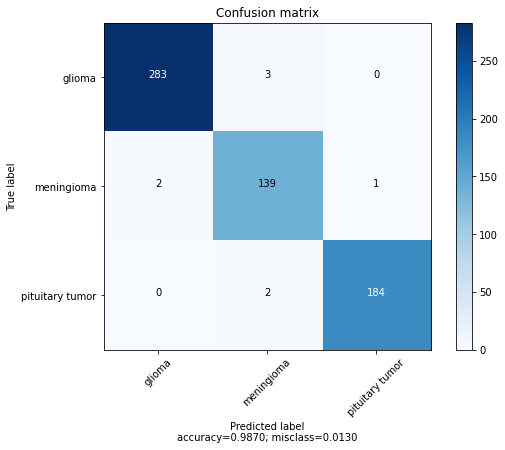

In [ ]:
confusion_mtx = confusion_matrix(y_test_new,pred)
cm = plot_confusion_matrix(confusion_mtx, target_names = labels, normalize=False)

In [ ]:
ind_list = np.argwhere((y_test_new == pred) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_test_new[i]}\nPredicted class: {pred[i]}')
        plt.show()

## **Experiment 3**: TL of EfficientNetB2

### **Transfer Learning**

In [ ]:
effnet = EfficientNetB2(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(3,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Multi class Brain tumor Clssification/Other Experiments/3 class/saved model/balanced data/effnetb2v2.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)

### **Training The Model**

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

In [1]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

NameError: name 'history' is not defined

### **Prediction**

In [ ]:
models = load_model('/content/drive/MyDrive/Multi class Brain tumor Clssification/Other Experiments/3 class/saved model/balanced data/effnetb2v2.h5')
pred = models.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [ ]:
loss,acc = models.evaluate(X_test,y_test,verbose = 1)
print("Test Accuracy: ",np.round(acc*100,2))

In [ ]:
print(classification_report(y_test_new,pred,target_names = labels,digits = 4))

In [ ]:
confusion_mtx = confusion_matrix(y_test_new,pred)
cm = plot_confusion_matrix(confusion_mtx, target_names = labels, normalize=False)

In [ ]:
ind_list = np.argwhere((y_test_new == pred) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_test_new[i]}\nPredicted class: {pred[i]}')
        plt.show()

## **Experiment 4**: TL of EfficientNetB0

In [ ]:
effnetb0 = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [ ]:
model3 = effnetb0.output
model3 = tf.keras.layers.GlobalAveragePooling2D()(model3)
model3 = tf.keras.layers.Dropout(rate=0.5)(model3)
model3 = tf.keras.layers.Dense(3,activation='softmax')(model3)
model3 = tf.keras.models.Model(inputs=effnetb0.input, outputs = model3)

In [ ]:
model3.summary()

In [ ]:
model3.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Multi class Brain tumor Clssification/Other Experiments/3 class/saved model/balanced data/effnetb0.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)

### **Training The Model**

In [ ]:
history = model3.fit(X_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### **Prediction**

In [ ]:
pred = model3.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

### **Evaluation**

In [ ]:
loss,acc = model3.evaluate(X_test,y_test,verbose = 1)
print("Test Accuracy: ",np.round(acc*100,2))

In [ ]:
print(classification_report(y_test_new,pred,target_names = labels))

In [ ]:
confusion_mtx = confusion_matrix(y_test_new,pred)
cm = plot_confusion_matrix(confusion_mtx, target_names = labels, normalize=False)

## **Experiment 5**: TL of EfficientNetB3

In [ ]:
effnetb3 = EfficientNetB3(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

43950080/43941136 [==============================] - 1s 0us/step


In [ ]:
model3 = effnetb3.output
model3 = tf.keras.layers.GlobalAveragePooling2D()(model3)
model3 = tf.keras.layers.Dropout(rate=0.5)(model3)
model3 = tf.keras.layers.Dense(3,activation='softmax')(model3)
model3 = tf.keras.models.Model(inputs=effnetb3.input, outputs = model3)

In [ ]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 240, 240, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 240, 240, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
model3.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Multi class Brain tumor Clssification/Other Experiments/3 class/saved model/balanced data/effnetb3.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)

### **Training The Model**

In [ ]:
history = model3.fit(X_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/50
297/297 [==============================] - ETA: 0s - loss: 0.1961 - accuracy: 0.9319
Epoch 1: val_accuracy improved from -inf to 0.94213, saving model to /content/drive/MyDrive/Multi class Brain tumor Clssification/Other Experiments/3 class/saved model/balanced data/effnetb3.h5
297/297 [==============================] - 226s 704ms/step - loss: 0.1961 - accuracy: 0.9319 - val_loss: 0.2076 - val_accuracy: 0.9421 - lr: 0.0010
Epoch 2/50
297/297 [==============================] - ETA: 0s - loss: 0.0849 - accuracy: 0.9719
Epoch 2: val_accuracy did not improve from 0.94213
297/297 [==============================] - 201s 677ms/step - loss: 0.0849 - accuracy: 0.9719 - val_loss: 18.1058 - val_accuracy: 0.8283 - lr: 0.0010
Epoch 3/50
297/297 [==============================] - ETA: 0s - loss: 0.0577 - accuracy: 0.9824
Epoch 3: val_accuracy did not improve from 0.94213
297/297 [==============================] - 202s 680ms/step - loss: 0.0577 - accuracy: 0.9824 - val_loss: 0.2255 - val_a

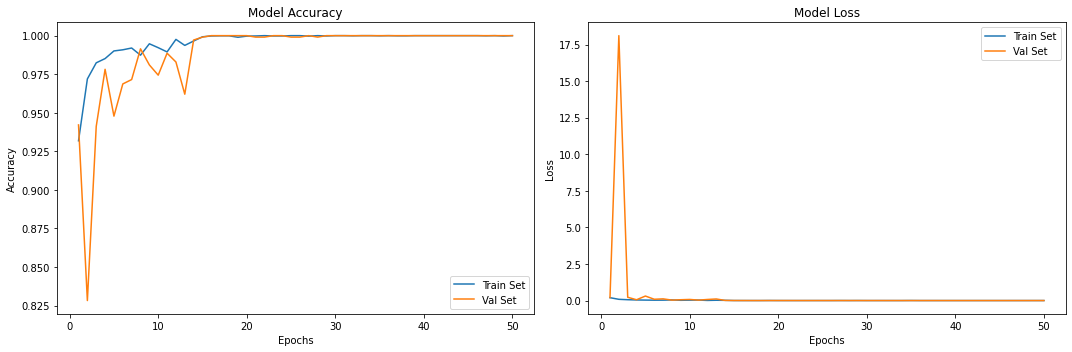

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### **Prediction**

In [ ]:
pred = model3.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

### **Evaluation**

In [ ]:
loss,acc = model3.evaluate(X_test,y_test,verbose = 1)
print("Test Accuracy: ",np.round(acc*100,2))

20/20 [==============================] - 3s 130ms/step - loss: 0.1878 - accuracy: 0.9821
Test Accuracy:  98.21


In [ ]:
print(classification_report(y_test_new,pred,target_names = labels))

                 precision    recall  f1-score   support

         glioma       1.00      0.99      0.99       286
     meningioma       0.96      0.96      0.96       142
pituitary tumor       0.97      0.99      0.98       186

       accuracy                           0.98       614
      macro avg       0.98      0.98      0.98       614
   weighted avg       0.98      0.98      0.98       614



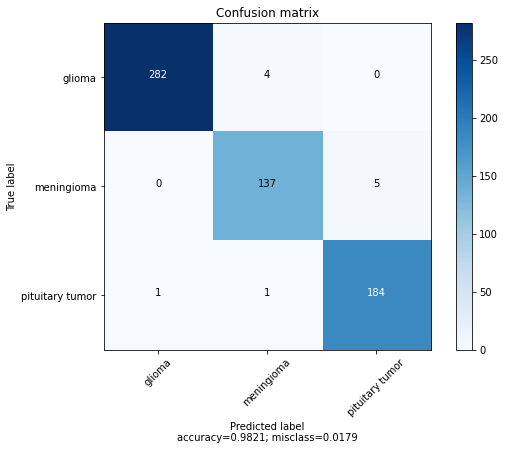

In [ ]:
confusion_mtx = confusion_matrix(y_test_new,pred)
cm = plot_confusion_matrix(confusion_mtx, target_names = labels, normalize=False)

## **Experiment 6**: TL of EfficientNetB4

In [ ]:
effnetb4 = EfficientNetB4(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

71696384/71686520 [==============================] - 2s 0us/step


In [ ]:
model3 = effnetb4.output
model3 = tf.keras.layers.GlobalAveragePooling2D()(model3)
model3 = tf.keras.layers.Dropout(rate=0.5)(model3)
model3 = tf.keras.layers.Dense(3,activation='softmax')(model3)
model3 = tf.keras.models.Model(inputs=effnetb4.input, outputs = model3)

In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 240, 240, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 240, 240, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 241, 241, 3)  0           ['normalization[0][0]']      

In [ ]:
model3.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Multi class Brain tumor Clssification/Other Experiments/3 class/saved model/balanced data/effnetb4.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)

### **Training The Model**

In [ ]:
history = model3.fit(X_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/50
297/297 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9372
Epoch 1: val_accuracy improved from -inf to 0.95446, saving model to /content/drive/MyDrive/Multi class Brain tumor Clssification/Other Experiments/3 class/saved model/balanced data/effnetb4.h5
297/297 [==============================] - 304s 912ms/step - loss: 0.1797 - accuracy: 0.9372 - val_loss: 0.1350 - val_accuracy: 0.9545 - lr: 0.0010
Epoch 2/50
297/297 [==============================] - ETA: 0s - loss: 0.0588 - accuracy: 0.9790
Epoch 2: val_accuracy improved from 0.95446 to 0.96964, saving model to /content/drive/MyDrive/Multi class Brain tumor Clssification/Other Experiments/3 class/saved model/balanced data/effnetb4.h5
297/297 [==============================] - 270s 909ms/step - loss: 0.0588 - accuracy: 0.9790 - val_loss: 0.0923 - val_accuracy: 0.9696 - lr: 0.0010
Epoch 3/50
297/297 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.9849
Epoch 3: val_accuracy imp

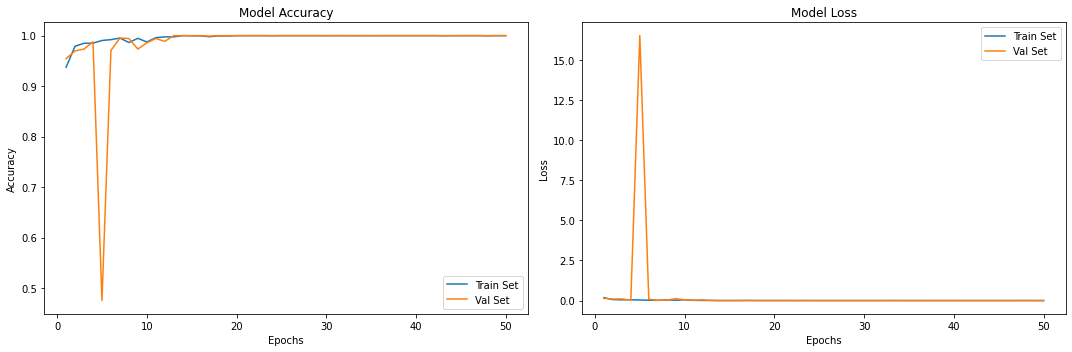

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### **Prediction**

In [ ]:
pred = model3.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

### **Evaluation**

In [ ]:
loss,acc = model3.evaluate(X_test,y_test,verbose = 1)
print("Test Accuracy: ",np.round(acc*100,2))

20/20 [==============================] - 3s 170ms/step - loss: 0.1470 - accuracy: 0.9805
Test Accuracy:  98.05


In [ ]:
print(classification_report(y_test_new,pred,target_names = labels))

                 precision    recall  f1-score   support

         glioma       0.99      0.99      0.99       286
     meningioma       0.96      0.96      0.96       142
pituitary tumor       0.97      0.98      0.98       186

       accuracy                           0.98       614
      macro avg       0.98      0.98      0.98       614
   weighted avg       0.98      0.98      0.98       614



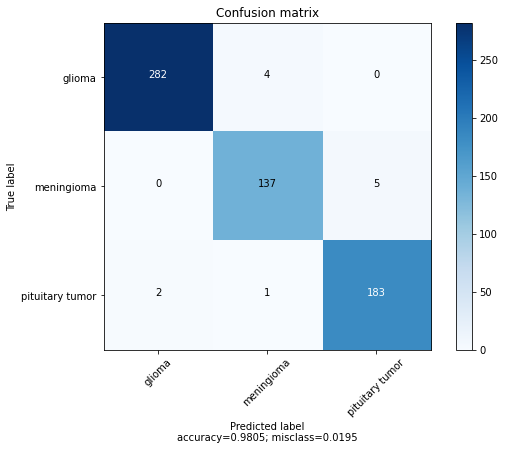

In [ ]:
confusion_mtx = confusion_matrix(y_test_new,pred)
cm = plot_confusion_matrix(confusion_mtx, target_names = labels, normalize=False)

# **Cross Dataset Validation**

## Load Dataset

In [ ]:
!unzip '/content/drive/MyDrive/Multi class Brain tumor Clssification/New Dataset/dataset.zip'

Archive:  /content/drive/MyDrive/Multi class Brain tumor Clssification/New Dataset/dataset.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma_tumor/image(22).jpg  
  inflating: Testing/glioma_tumor/image(23).jpg  
  inflating: Testing/glioma_tumor/image(24).jpg  
  infl

In [ ]:
labels = ['glioma_tumor','meningioma_tumor','pituitary_tumor']

In [ ]:
import imutils

In [ ]:
X_train = []
y_train = []
X_test = []
y_test = []

print("Train Set")
print("===========")

image_size = 240
for i in labels:
    folderPath = os.path.join('/content/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = crop_brain_contour(img, plot = False)
        img = cv2.resize(img,(image_size, image_size))
        
        X_train.append(img)
        y_train.append(i)
                
X_train = np.array(X_train)
y_train = np.array(y_train)

print("Test Set")
print("=========")
for i in labels:
    folderPath = os.path.join('/content/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = crop_brain_contour(img, plot = False)
        img = cv2.resize(img,(image_size, image_size))
        X_test.append(img)
        y_test.append(i)
                
X_test = np.array(X_test)
y_test = np.array(y_test)

Train Set


100%|██████████| 827/827 [00:03<00:00, 219.67it/s]


Test Set


100%|██████████| 74/74 [00:00<00:00, 142.25it/s]


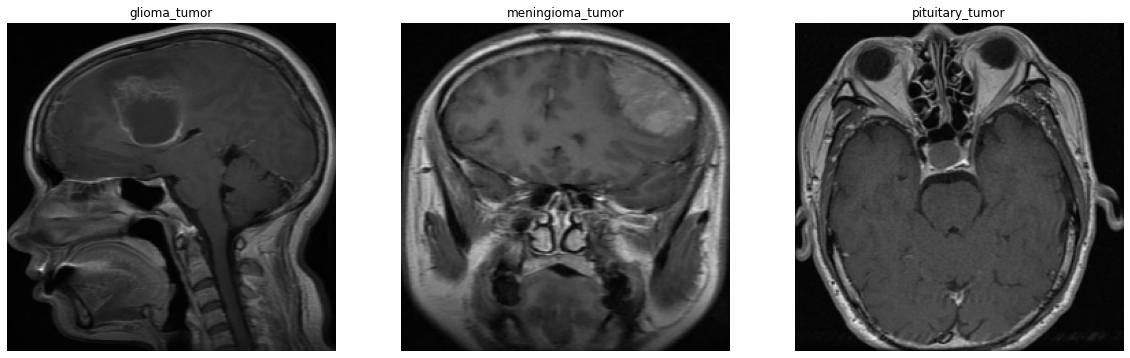

In [ ]:
k=0
fig, ax = plt.subplots(1,3,figsize=(20,20))

for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

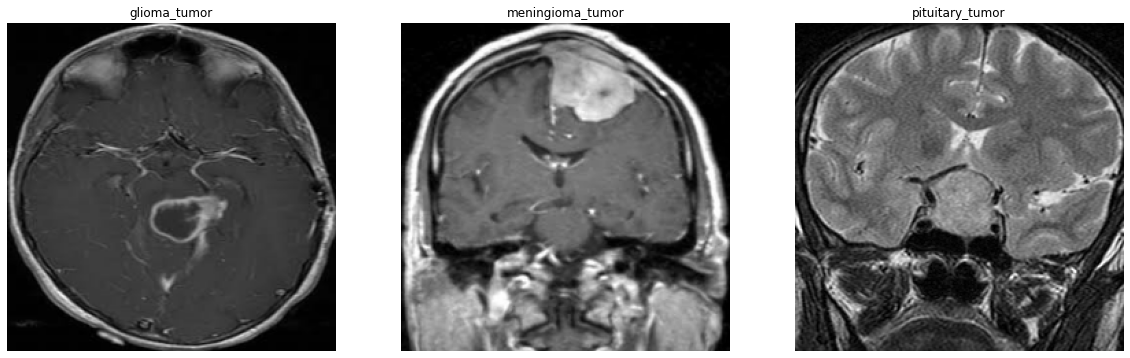

In [ ]:
#  sample images in test set

k=0
fig, ax = plt.subplots(1,3,figsize=(20,20))

for i in labels:
    j=0
    while True :
        if y_test[j]==i:
            ax[k].imshow(X_test[j])
            ax[k].set_title(y_test[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(2475, 240, 240, 3)

In [ ]:
print("x train=",X_train.shape)
print("y train=",y_train.shape)

print("x test=",X_test.shape)
print("y test=",y_test.shape)


x train= (2475, 240, 240, 3)
y train= (2475,)
x test= (289, 240, 240, 3)
y test= (289,)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


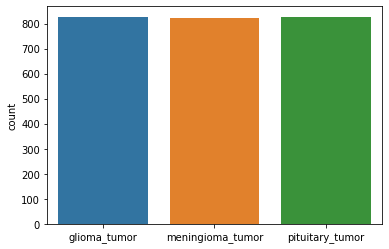

In [ ]:
sns.countplot(y_train)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


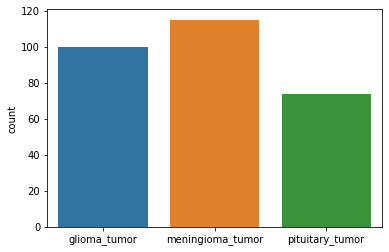

In [ ]:
sns.countplot(y_test)

In [ ]:
# label encoding

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

## Load Models

In [ ]:
model1 = load_model("/content/drive/MyDrive/Multi class Brain tumor Clssification/Other Experiments/3 class/saved model/balanced data/effnetb0.h5")
model2 = load_model("/content/drive/MyDrive/Multi class Brain tumor Clssification/Other Experiments/3 class/saved model/balanced data/effnetb1.h5")
model3 = load_model("/content/drive/MyDrive/Multi class Brain tumor Clssification/Other Experiments/3 class/saved model/balanced data/effnetb2v2.h5")
model4 = load_model("/content/drive/MyDrive/Multi class Brain tumor Clssification/Other Experiments/3 class/saved model/balanced data/effnetb3.h5")
model5 = load_model("/content/drive/MyDrive/Multi class Brain tumor Clssification/Other Experiments/3 class/saved model/balanced data/effnetb4.h5")


## Predict and Evaluate on Train Data

### 1. EfficientNetB0

In [ ]:
pred = model1.predict(X_train)
pred = np.argmax(pred,axis=1)
y_train_new = np.argmax(y_train,axis=1)

loss,acc = model1.evaluate(X_train,y_train,verbose = 1)
print("Training Accuracy: ",np.round(acc*100,2))

78/78 [==============================] - 180s 2s/step - loss: 0.4363 - accuracy: 0.8929
Training Accuracy:  89.29


In [ ]:
print(classification_report(y_train_new,pred,target_names = labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.90      0.95      0.92       826
meningioma_tumor       0.96      0.77      0.85       822
 pituitary_tumor       0.84      0.96      0.90       827

        accuracy                           0.89      2475
       macro avg       0.90      0.89      0.89      2475
    weighted avg       0.90      0.89      0.89      2475



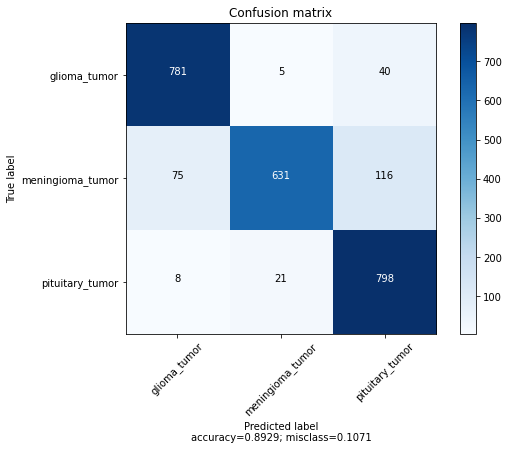

In [ ]:
confusion_mtx = confusion_matrix(y_train_new,pred)
cm = plot_confusion_matrix(confusion_mtx, target_names = labels, normalize=False)

### 2. EfficientNetB1

In [ ]:
pred = model2.predict(X_train)
pred = np.argmax(pred,axis=1)
y_train_new = np.argmax(y_train,axis=1)

loss,acc = model2.evaluate(X_train,y_train,verbose = 1)
print("Training Accuracy: ",np.round(acc*100,2))

78/78 [==============================] - 259s 3s/step - loss: 0.2584 - accuracy: 0.9390
Training Accuracy:  93.9


In [ ]:
print(classification_report(y_train_new,pred,target_names = labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.98      0.95       826
meningioma_tumor       0.97      0.86      0.91       822
 pituitary_tumor       0.92      0.98      0.95       827

        accuracy                           0.94      2475
       macro avg       0.94      0.94      0.94      2475
    weighted avg       0.94      0.94      0.94      2475



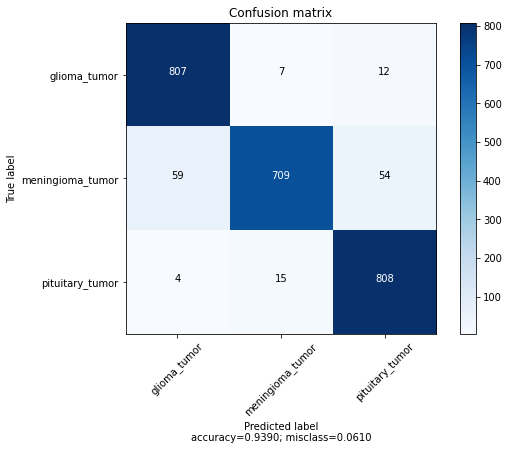

In [ ]:
confusion_mtx = confusion_matrix(y_train_new,pred)
cm = plot_confusion_matrix(confusion_mtx, target_names = labels, normalize=False)

### 3. EfficientNetB2

In [ ]:
pred = model3.predict(X_train)
pred = np.argmax(pred,axis=1)
y_train_new = np.argmax(y_train,axis=1)

loss,acc = model3.evaluate(X_train,y_train,verbose = 1)
print("Training Accuracy: ",np.round(acc*100,2))

78/78 [==============================] - 10s 101ms/step - loss: 0.2398 - accuracy: 0.9414
Training Accuracy:  94.14


In [ ]:
print(classification_report(y_train_new,pred,target_names = labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.98      0.95       826
meningioma_tumor       0.97      0.86      0.91       822
 pituitary_tumor       0.93      0.98      0.95       827

        accuracy                           0.94      2475
       macro avg       0.94      0.94      0.94      2475
    weighted avg       0.94      0.94      0.94      2475



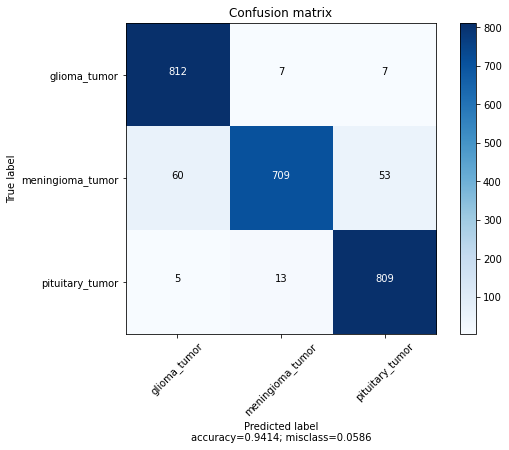

In [ ]:
confusion_mtx = confusion_matrix(y_train_new,pred)
cm = plot_confusion_matrix(confusion_mtx, target_names = labels, normalize=False)

### 4. EfficientNetB3

In [ ]:
pred = model4.predict(X_train)
pred = np.argmax(pred,axis=1)
y_train_new = np.argmax(y_train,axis=1)

loss,acc = model4.evaluate(X_train,y_train,verbose = 1)
print("Training Accuracy: ",np.round(acc*100,2))

78/78 [==============================] - 464s 6s/step - loss: 0.5548 - accuracy: 0.8832
Training Accuracy:  88.32


In [ ]:
print(classification_report(y_train_new,pred,target_names = labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.90      0.92       826
meningioma_tumor       0.97      0.77      0.86       822
 pituitary_tumor       0.78      0.98      0.87       827

        accuracy                           0.88      2475
       macro avg       0.90      0.88      0.88      2475
    weighted avg       0.90      0.88      0.88      2475



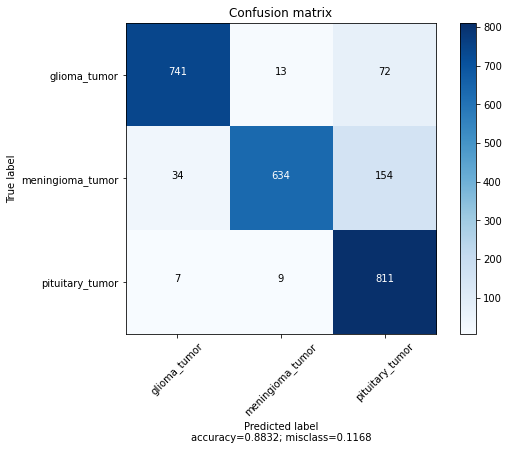

In [ ]:
confusion_mtx = confusion_matrix(y_train_new,pred)
cm = plot_confusion_matrix(confusion_mtx, target_names = labels, normalize=False)

### 5. EfficientNetB4

In [ ]:
pred = model5.predict(X_train)
pred = np.argmax(pred,axis=1)
y_train_new = np.argmax(y_train,axis=1)

loss,acc = model5.evaluate(X_train,y_train,verbose = 1)
print("Training Accuracy: ",np.round(acc*100,2))

78/78 [==============================] - 667s 8s/step - loss: 0.4011 - accuracy: 0.8933
Training Accuracy:  89.33


In [ ]:
print(classification_report(y_train_new,pred,target_names = labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.90      0.98      0.94       826
meningioma_tumor       0.99      0.72      0.83       822
 pituitary_tumor       0.83      0.99      0.90       827

        accuracy                           0.89      2475
       macro avg       0.91      0.89      0.89      2475
    weighted avg       0.91      0.89      0.89      2475



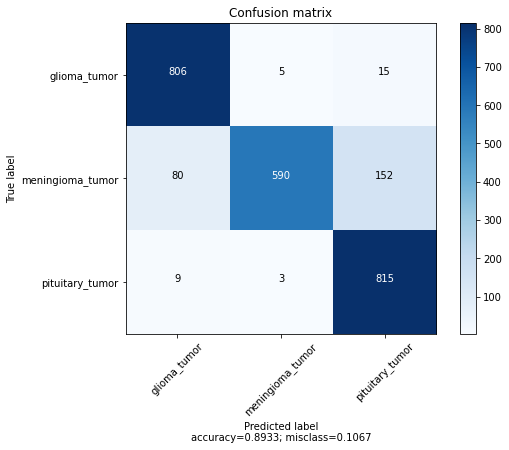

In [ ]:
confusion_mtx = confusion_matrix(y_train_new,pred)
cm = plot_confusion_matrix(confusion_mtx, target_names = labels, normalize=False)

# **Application Phase**

In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [ ]:
uploader = widgets.FileUpload()
display(uploader)

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

# **GradCam Visualization**

In [ ]:
import matplotlib.cm as cm
def display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4,preds=[0,0,0,0], plot=None):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image

    # Display Grad CAM
    plot.imshow(superimposed_img)
    plot.axis('off')


In [ ]:
def gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output,  model.output]
    )
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
        
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# Extracting False Negatives 
def evaluate_model(model, data, labels):
  false_predictions = []
  for img, label in zip(data, labels):
    image = image = tf.expand_dims(img, axis=0)
    predicted = model.predict(image)
    true_label= np.argmax(label)
    predicted_label = np.argmax(predicted)
    confidence = predicted[0][predicted_label]

    if true_label != predicted_label:
      false_predictions.append([img, true_label, predicted_label, confidence, predicted])
  return false_predictions

In [ ]:
# Extracting False Negatives 
def evaluate_model(model, data, labels):
  true_predictions = []
  for img, label in zip(data, labels):
    image = tf.expand_dims(img, axis=0)
    predicted = model.predict(image)
    true_label= np.argmax(label)
    predicted_label = np.argmax(predicted)
    confidence = predicted[0][predicted_label]

    if true_label == predicted_label:
      true_predictions.append([img, true_label, predicted_label, confidence, predicted])
  return true_predictions

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
def sove_plots(path, size, model, last_conv_layer_name):
  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 10))
  plt.subplots_adjust(bottom=0)
  img_array = get_img_array(path,size)
  img= cv2.imread(path)
  # Remove last layer's softmax
  model.layers[-1].activation = None
    # Print what the top predicted class is
  preds = model.predict(img_array)
  
  i = np.argmax(preds[0])
  print(i)
  if i==0:
    actual = "glioma"
    predicted_label_class = "glioma"
  elif i==1:
    actual = "meningioma"
    predicted_label_class = "meningioma"
  elif i==2:
    actual = "pituitary tumor"
    predicted_label_class = "pituitary tumor"
   
  title = "True Label: {} \n Predicted Label: {} \n".format(
        actual, predicted_label_class)
  plt.axis('off')
  heatmap = gradcam_heatmap(img_array, model, last_layer_name)
  heatmap = np.reshape(heatmap, (8,8)) # 7,7
  display_gradcam(img, heatmap, preds=preds[0], plot=ax1)
  _ = ax2.imshow(img)
  _ = ax3.imshow(heatmap)
  ax1.set_title("GradCam")
  ax2.set_title(title)
  ax3.set_title('Attention Map')
  plt.show()
  plt.close()
  print('------------')


## Load Test Data

In [ ]:
classes = ['glioma','meningioma','pituitary tumor']
X_test = []
y_test = []

image_size = 240

print("Test Set")
print("=========")

for i in classes:
    folderPath = os.path.join('/content/Augmented + Balanced Split/80-20','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_test.append(img)
        y_test.append(i)
                
X_test = np.array(X_test)
y_test = np.array(y_test)

Test Set


100%|██████████| 186/186 [00:00<00:00, 232.13it/s]


In [ ]:
X_test, y_test = shuffle(X_test,y_test, random_state=101)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)



In [ ]:
y_test_new = np.argmax(y_test,axis=1)

## Load Model

In [ ]:
model = load_model('/content/drive/MyDrive/Multi class Brain tumor Clssification/Other Experiments/3 class/saved model/balanced data/effnetb1.h5')

In [ ]:
last_layer_name = 'top_activation'

## Gliomas

0


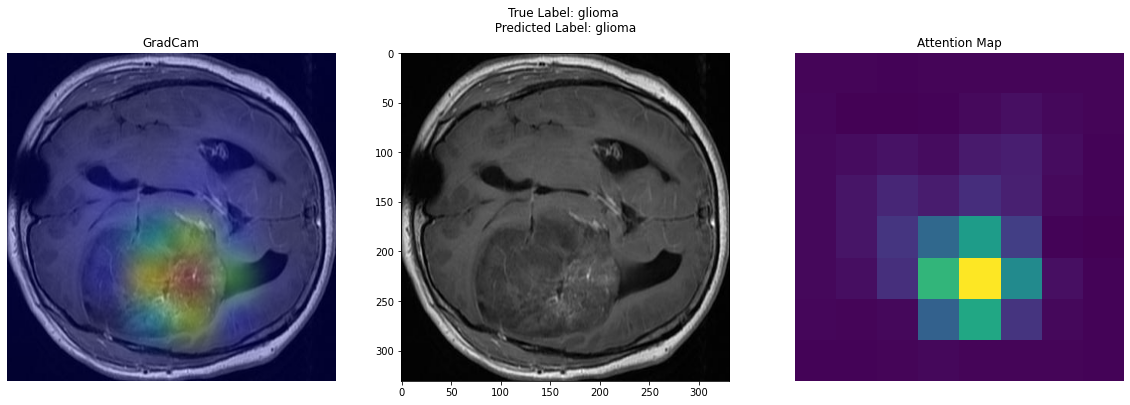

------------


In [ ]:
path = '/content/Augmented + Balanced Split/80-20/test/glioma/image_1005.png'
size = (240,240)
sove_plots(path, size, model, last_layer_name)

0


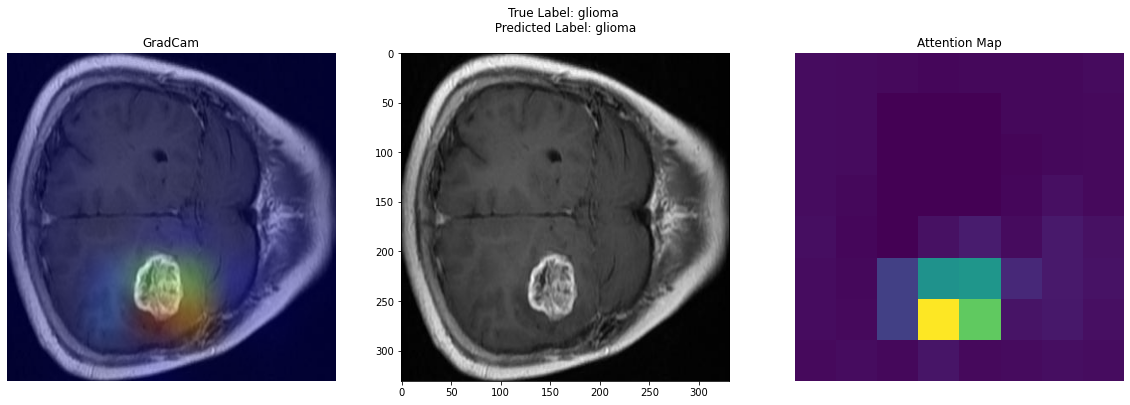

------------


In [ ]:
path = '/content/Augmented + Balanced Split/80-20/test/glioma/image_1036.png'
size = (240,240)
sove_plots(path, size, model, last_layer_name)

## Meningioma

1


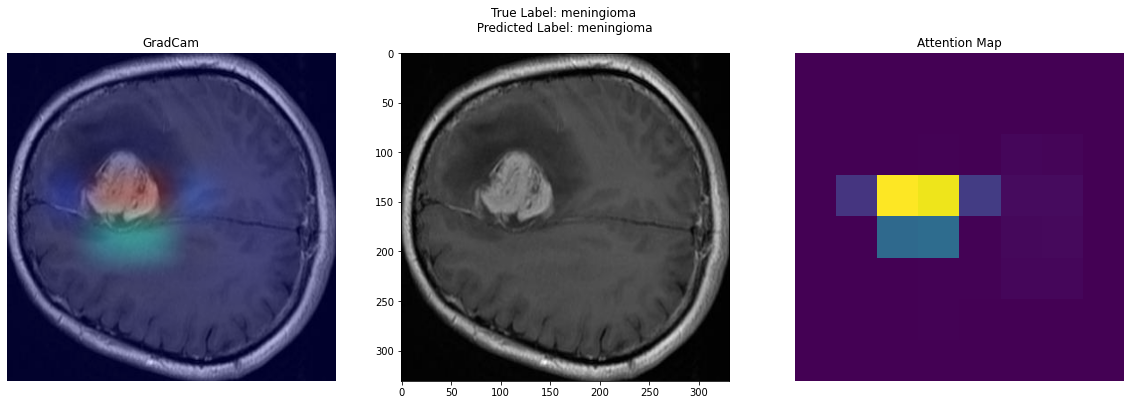

------------


In [ ]:
path = '/content/Augmented + Balanced Split/80-20/test/meningioma/image_104.png'
size = (240,240)
sove_plots(path, size, model, last_layer_name)

1


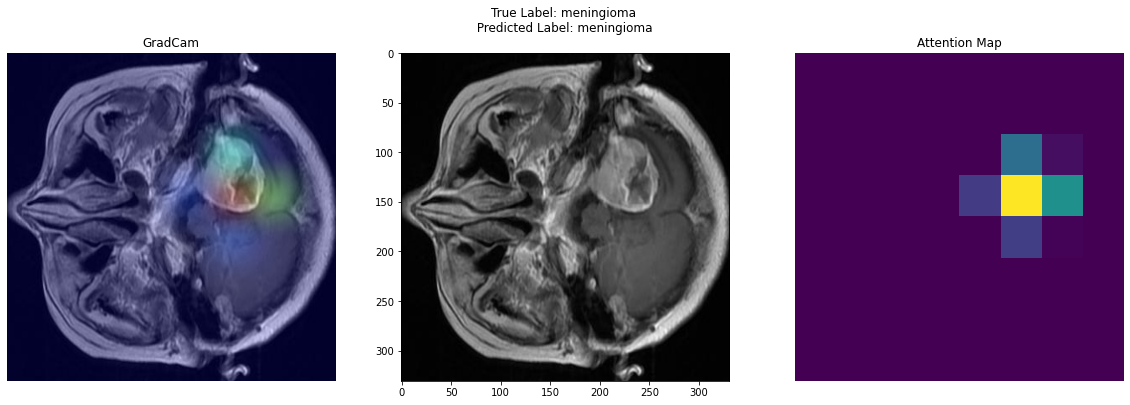

------------


In [ ]:
path = '/content/Augmented + Balanced Split/80-20/test/meningioma/image_116.png'
size = (240,240)
sove_plots(path, size, model, last_layer_name)

## Pituitary tumor

2


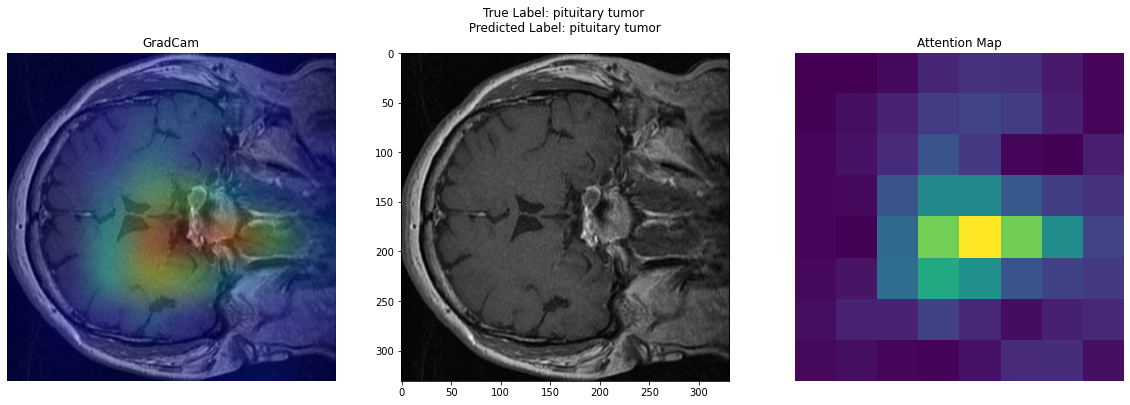

------------


In [ ]:
path = '/content/Augmented + Balanced Split/80-20/test/pituitary tumor/image_11.png'
size = (240,240)
sove_plots(path, size, model, last_layer_name)

2


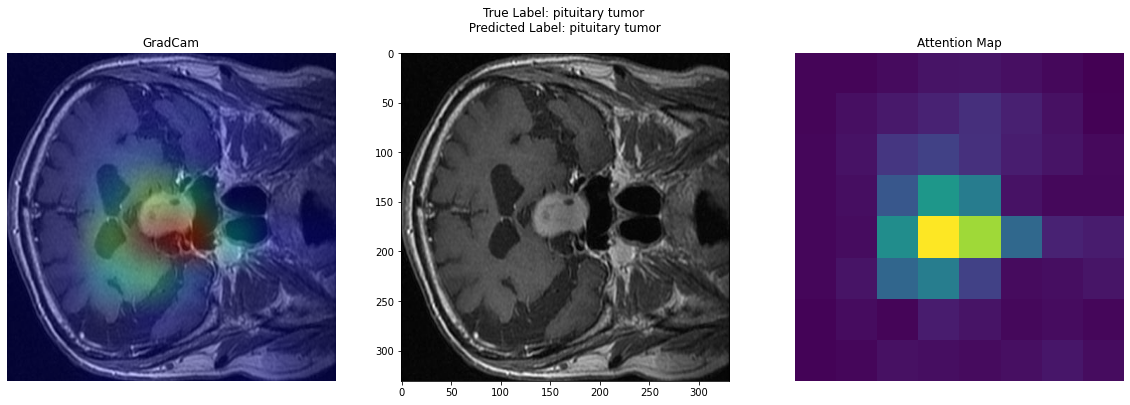

------------


In [ ]:
path = '/content/Augmented + Balanced Split/80-20/test/pituitary tumor/image_130.png'
size = (240,240)
sove_plots(path, size, model, last_layer_name)

## Looping

In [ ]:
classes = ['glioma','meningioma','pituitary tumor']

size = (240,240)

print("Test Set")
print("=========")

for i in classes:
    folderPath = os.path.join('/content/Augmented + Balanced Split/80-20','test',i)
    for j in tqdm(os.listdir(folderPath)):
        sove_plots(os.path.join(folderPath,j),size,model,last_layer_name)
        